### Multi-input Network - Pytorch

Prediction action sequence that connects two observations

### Important

- unify train function for the different training modalities !

###### waypoint executer
- write program that finds path between waypoints (using balck and white image as map the agent can walk on (?))

###### data
- check image normalization (with transform!): rescale /255
- black and white ?

###### training
- Build network that predicts multiple actions (both as vector and with labels) 
- check whether difference image gives sensible predictions
- are weights shared correctly within the two input networks?

---------------------------------------------------------------------------
---------------------------------------------------------------------------

### Optional

###### structure
- look into general structure of the NeurIPS project, Martius Project (https://github.com/martius-lab/PPGS) or Dreamer

###### saving
- create hash and .csv or .md file that collects all the different saved networks (and their associated parameter settings)

###### training
- write dict to pass to train function with parameters (+ possibility to have addititonal outputs)
- Feedforward network likely could be improved by making use of dropout
- autosave models (in runs folder!)
- fix the naming (of how models are saved, configs are saved, runs are called)

###### tensorboard
- write tensorboard integration for gradients
- collect more image visuals / intermediate predictions (compute confusion matrix?)

###### colab
- train models using colab

In [ ]:
'''
Imports external and own libraries
'''

import pickle

import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader

from prettytable import PrettyTable

# own
import collector
import action
import world
import plot
import preprocess
import nets
import train

In [2]:
'''
Load data with pickle (deserialize)
'''
with open('datasets/oracle_data.pickle', 'rb') as handle:
    oracle_data = pickle.load(handle)

with open('datasets/oracle_reversed_data.pickle', 'rb') as handle:
    oracle_reversed_data = pickle.load(handle)

with open('datasets/oracle_random_data.pickle', 'rb') as handle:
    oracle_random_data = pickle.load(handle)

with open('datasets/oracle_reversed_random_data.pickle', 'rb') as handle:
    oracle_reversed_random_data = pickle.load(handle)
    
with open('datasets/random_data.pickle', 'rb') as handle:
    random_data = pickle.load(handle)
    
with open('datasets/tmaze_random_reverse_data.pickle', 'rb') as handle:
    tmaze_random_reverse_data = pickle.load(handle)

In [3]:
'''
Use Dataloader to make the data ready for the training loop
'''

dataset = preprocess.split_n_steps_between(tmaze_random_reverse_data, n=2)

single_class_encoding_dic = {}
counter = 0
for i in range(0, 4):
    for j in range(0, 4):
        single_class_encoding_dic[str([i, j])] = counter
        counter += 1

actions_recoded = []
for actions in dataset['actions']:
    actions_recoded.append([single_class_encoding_dic[str(actions)]])
    
dataset['actions'] = actions_recoded

train_data, test_data = preprocess.split_data(dataset, 0.8)

# preprocess trainingset 
oracle_train_data = preprocess.ObtainDualDataset(train_data, 'observationsA','observationsB', 'actions')
oracle_test_data = preprocess.ObtainDualDataset(test_data, 'observationsA','observationsB', 'actions')

# build dataloader (tensor format)
batch_size = 64
dataset_loader_train_data = DataLoader(oracle_train_data, batch_size=batch_size, shuffle=True)
dataset_loader_test_data = DataLoader(oracle_test_data, batch_size=batch_size, shuffle=True)

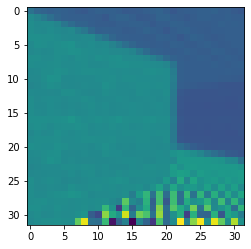

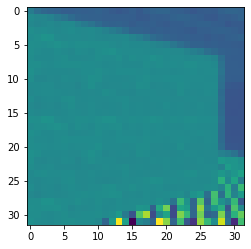

[10]
3
1


In [4]:
imagesA, imagesB, labels = next(iter(oracle_train_data))

from matplotlib import pyplot as plt

plt.imshow(imagesA[0])
plt.show()

plt.imshow(imagesB[0])
plt.show()

print(labels)

print(len(imagesA))
print(len(labels))

In [9]:
'''
Initialize dual input model
'''

DualInput_model = nets.DualInput()
summary(DualInput_model, [(3,32,32), (3,32,32)])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
         MaxPool2d-2            [-1, 6, 14, 14]               0
            Conv2d-3           [-1, 16, 10, 10]           2,416
         MaxPool2d-4             [-1, 16, 5, 5]               0
            Conv2d-5            [-1, 6, 28, 28]             456
         MaxPool2d-6            [-1, 6, 14, 14]               0
            Conv2d-7           [-1, 16, 10, 10]           2,416
         MaxPool2d-8             [-1, 16, 5, 5]               0
            Linear-9                  [-1, 120]          96,120
           Linear-10                   [-1, 84]          10,164
           Linear-11                   [-1, 16]           1,360
Total params: 113,388
Trainable params: 113,388
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 36.00
Forward

In [ ]:
'''
Make use of TensorBoard for visualizing logged results
'''

%load_ext tensorboard
%tensorboard --logdir=runs

In [6]:
from torch.utils.tensorboard import SummaryWriter
import torchvision
import torch
import plot
from tqdm.auto import tqdm

def DualInput(train_data, val_data, net, criterion, optimizer, steps):
    '''
    Main training loop
    Input: dataset_loader, network, training_loss, optimizer, step size
    Output: trained network
    '''

    train_loss = []
    test_loss = []
    train_acc = []
    test_acc = []
    writer = SummaryWriter()

    imagesA, imagesB, labels = next(iter(train_data))
    grid = torchvision.utils.make_grid(imagesA)
    writer.add_image('images', grid, 0)
    writer.add_graph(net, [imagesA, imagesB])

    with tqdm(total=steps, unit =" Episode", desc ="Progress") as pbar:
        for epoch in range(steps):  # loop over the dataset multiple times

            train_running_loss = 0.0

            train_correct = 0
            train_total = 0

            for i, data in enumerate(train_data, 0):
                # get the inputs; data is a list of [inputs, labels]
                inputsA, inputB, labels = data
                labels = labels[0]
                labels = labels.to(torch.long)
                
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward + backward + optimize
                outputs = net(inputsA, inputB)

                # loss
                loss = criterion(outputs.squeeze(), labels)
                loss.backward()
                optimizer.step()

                # compute acc
                _, predicted = torch.max(outputs.data, 1)
                train_total += labels.size(0)
                train_correct += (predicted == labels).sum().item()

                # track loss statistics
                train_running_loss += loss.item()

                test_running_loss = 0.0

                test_correct = 0
                test_total = 0

                # same for validation set
                with torch.no_grad():
                    for data in val_data:
                        inputsA, inputsB, labels = data
                        labels = labels[0]
                        labels = labels.to(torch.long)
                        
                        outputs = net(inputsA, inputsB)
                        loss = criterion(outputs.squeeze(), labels)
                        test_running_loss += loss.item()

                        _, predicted = torch.max(outputs.data, 1)
                        test_total += labels.size(0)
                        test_correct += (predicted == labels).sum().item()

            # tensorboard logs
            writer.add_scalar('Loss/train', (train_running_loss/len(train_data)), epoch)
            writer.add_scalar('Loss/test', (test_running_loss/len(val_data)), epoch)
            writer.add_scalar('Accuracy/train', (100 * train_correct / train_total), epoch)
            writer.add_scalar('Accuracy/test', (100 * test_correct / test_total), epoch)

            # plotting logs
            train_loss.append(train_running_loss/len(train_data))
            test_loss.append(test_running_loss/len(val_data))
            train_acc.append(100 * train_correct / train_total)
            test_acc.append(100 * test_correct / test_total)
            pbar.update(1)

            if epoch % 10 == 0:
                print(f'Epoch: {epoch + 1}, Train Loss: {(train_running_loss/len(train_data)):.4}, Train Acc: {(100 * train_correct / train_total):.4} %,  Test Loss: {(test_running_loss/len(val_data)):.4}, Test Acc: {(100 * test_correct / test_total):.4} %,')

    writer.close()
    print('Finished Training')
    return net, train_loss, test_loss, train_acc, test_acc

In [10]:
'''
Train the network
- obtained with SGD, lr=0.01, mometum=0.9, 100 episodes: train acc. 50%, test acc. 48%
- obtained with SGD, lr=0.01, mometum=0.9, 200 episodes: train acc. 55%, test acc. 37%
- obtained with SGD, lr=0.01, mometum=0.9, 300 episodes: train acc. 60%, test acc. 29%
'''
# DualInput_model = nets.DualInput()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(DualInput_model.parameters(), lr=0.01, momentum=0.9) # RMSProp, Adam, SDG (momentum=0.9)
#optimizer = optim.RMSprop(DualInput_model.parameters(), lr=0.001)

# Print model's state_dict
print("Model's state_dict:")
for param_tensor in DualInput_model.state_dict():
    print(param_tensor, "\t", DualInput_model.state_dict()[param_tensor].size())

# Print optimizer's state_dict
print("\nOptimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

episodes = 500
DualInput_model, train_loss, test_loss, train_acc, test_acc  = DualInput(dataset_loader_train_data, dataset_loader_test_data, DualInput_model, criterion, optimizer, episodes)


Model's state_dict:
conv1.weight 	 torch.Size([6, 3, 5, 5])
conv1.bias 	 torch.Size([6])
conv2.weight 	 torch.Size([16, 6, 5, 5])
conv2.bias 	 torch.Size([16])
fc1.weight 	 torch.Size([120, 800])
fc1.bias 	 torch.Size([120])
fc2.weight 	 torch.Size([84, 120])
fc2.bias 	 torch.Size([84])
fc3.weight 	 torch.Size([16, 84])
fc3.bias 	 torch.Size([16])

Optimizer's state_dict:
state 	 {}
param_groups 	 [{'lr': 0.01, 'momentum': 0.9, 'dampening': 0, 'weight_decay': 0, 'nesterov': False, 'params': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]}]


Progress:   0%|          | 0/500 [00:00<?, ? Episode/s]

Epoch: 1, Train Loss: 2.776, Train Acc: 5.441 %,  Test Loss: 2.778, Test Acc: 6.516 %,
Epoch: 11, Train Loss: 2.769, Train Acc: 7.004 %,  Test Loss: 2.78, Test Acc: 5.514 %,
Epoch: 21, Train Loss: 2.769, Train Acc: 7.129 %,  Test Loss: 2.783, Test Acc: 5.514 %,
Epoch: 31, Train Loss: 2.769, Train Acc: 7.129 %,  Test Loss: 2.781, Test Acc: 5.514 %,
Epoch: 41, Train Loss: 2.769, Train Acc: 7.004 %,  Test Loss: 2.78, Test Acc: 6.516 %,
Epoch: 51, Train Loss: 2.769, Train Acc: 7.442 %,  Test Loss: 2.78, Test Acc: 6.767 %,
Epoch: 61, Train Loss: 2.769, Train Acc: 6.942 %,  Test Loss: 2.784, Test Acc: 6.516 %,
Epoch: 71, Train Loss: 2.769, Train Acc: 6.817 %,  Test Loss: 2.778, Test Acc: 6.266 %,
Epoch: 81, Train Loss: 2.769, Train Acc: 6.692 %,  Test Loss: 2.785, Test Acc: 6.767 %,
Epoch: 91, Train Loss: 2.768, Train Acc: 7.129 %,  Test Loss: 2.785, Test Acc: 6.015 %,
Epoch: 101, Train Loss: 2.768, Train Acc: 7.442 %,  Test Loss: 2.782, Test Acc: 6.767 %,
Epoch: 111, Train Loss: 2.768, Trai

In [ ]:
'''
Plot loss and accuracy curves for training and test set
'''

plot.plot_losses(train_loss, test_loss)
plot.plot_acc(train_acc, test_acc, smooth=True)

In [ ]:
'''
Show example classifications and plot confusion matrix
'''

plot.show_example_classificataions(dataset_loader_train_data, DualInput_model, amount=8)
plot.plot_confusion_matrix(dataset_loader_train_data, model)

In [ ]:
import torchvision
import torch
from matplotlib import pyplot as plt

classes_expl = {0: 'turn left', 1: 'turn right', 2: 'walk forwards', 3: 'walk backwards'}

index = 4

imageA = dataset['observationsA'][index]
imageB = dataset['observationsB'][index]
lstval = [classes_expl[key] for key in dataset['actions'][index]]

plt.imshow(imageA)
plt.show()

print(lstval)

plt.imshow(imageB)
plt.show()

In [ ]:
# integrate into TensorBoard 

#for name, param in net.named_parameters():
#    print(name, param.grad.abs().sum())
#print('------------------')

In [ ]:
# problem: the label needs to be a tensor as well!
# important when one wants to make multi step predictions!

In [ ]:
# how many classes do we need?
print('single step', 4)
print('two steps', 4**2)
print('three step', 4**3)
print('four step', 4**4)
print('five step', 4**5)

In [ ]:

# build the dictionary myself!    

In [ ]:
'''
Preprocess images (Normalize inputs)
'''

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor()
])

dataloader = torch.utils.data.DataLoader(oracle_train_data, batch_size=4096, shuffle=False, num_workers=4)

pop_mean = []
pop_std0 = []
pop_std1 = []
for i, data in enumerate(dataloader, 0):
    # shape (batch_size, 3, height, width)
    numpy_image = data['image'].numpy()
    
    # shape (3,)
    batch_mean = np.mean(numpy_image, axis=(0,2,3))
    batch_std0 = np.std(numpy_image, axis=(0,2,3))
    batch_std1 = np.std(numpy_image, axis=(0,2,3), ddof=1)
    
    pop_mean.append(batch_mean)
    pop_std0.append(batch_std0)
    pop_std1.append(batch_std1)

# shape (num_iterations, 3) -> (mean across 0th axis) -> shape (3,)
pop_mean = np.array(pop_mean).mean(axis=0)
pop_std0 = np.array(pop_std0).mean(axis=0)
pop_std1 = np.array(pop_std1).mean(axis=0)